<a href="https://colab.research.google.com/github/DaJaCruz/PhD/blob/main/RNN_many2one_BidirectionalLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages

import tensorflow as tf
import pandas as pd # Pandas dataframe (very common in ML)
import numpy as np # import numpy to handle a lot of things!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM#, CuDNNLSTM
import matplotlib.pyplot as plt # import plotting tools to create figures
from IPython.display import display, Math # to print with Latex math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import cm # to change colors of surface plots

# Uncomment line below if you want to enable live rotation of the surface plots.
#%matplotlib notebook


In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
!apt install cm-super

In [ ]:
# Basic plotting tools needed in Python.

#%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
#plt.style.use("seaborn") # style for plotting that comes from seaborn
FS = 26  # Font Size
plt.rcParams['axes.facecolor'] = (0.97, 0.97, 0.97)
plt.rcParams['figure.facecolor'] = (1, 1, 1)
plt.rcParams["font.family"] = "sans"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['font.size'] = FS
params = {"ytick.color": (0, 0, 0),
          "xtick.color": (0, 0, 0),
          "grid.color": (.9, .9, .9),
          "text.color": (0, 0, 0),
          "axes.labelcolor": (0, 0, 0),
          "axes.edgecolor": (.15, .15, .15)#,
          #"text.usetex": True
          }
plt.rcParams.update(params)
linewidth=3.0

In [ ]:
# import raw data
url = 'https://raw.githubusercontent.com/DaJaCruz/PhD/main/data91_all.csv'
df = pd.read_csv(url, delimiter=';')

In [ ]:

# Split raw data in Input (X) and Output (Y) data
X_data_raw = df.loc[:,['Input_4','Input_5']].values
Y_data_raw = df.loc[:,['Output_1','Output_3']].values

In [ ]:
_, idx = np.unique(Y_data_raw, axis=0, return_index=True)
Y_data_unique_sorted = Y_data_raw[np.sort(idx)]
Y_dat_unique = Y_data_unique_sorted[:, 0].reshape(-1, 1)
print(X_data_raw.shape, Y_data_unique_sorted.shape)


(45500, 2) (91, 2)


In [ ]:
# Reshape data 
X_data_shaped = X_data_raw.reshape((91, 500, 2))
Y_data_shaped = Y_dat_unique.reshape((91, 1, 1))

In [ ]:
#Select the number of cases used 
n_cases = 20
total_n_points= n_cases*500
X_data = X_data_shaped[:n_cases, :, :]
Y_data = Y_data_shaped[:n_cases, :, :]

In [ ]:
#Reshape X_data and Y_data to Normalization operation
X_data_reshaped_norm=X_data.reshape(total_n_points, 2)
Y_data_reshaped_norm=Y_data.reshape(n_cases, 1)

In [ ]:
#
#Scale Inputs with a [-1,1] scaler
scaler_x = MinMaxScaler(feature_range=(-1,1))
#
# Scaling inputs with a Standard Scaler:
#scaler_x = StandardScaler()
#
scaler_x.fit(X_data_reshaped_norm)# fit the scaler to the input data
#
X_data_scaled_shaped=scaler_x.transform(X_data_reshaped_norm) # scale the input data (the whole dataset)
#
#Scale Inputs with a [-1,1] scaler
scaler_y = MinMaxScaler(feature_range=(-1,1))
#
# Scaling inputs with a Standard Scaler:
#scaler_y = StandardScaler()
#
scaler_y.fit(Y_data_reshaped_norm) # fit the scaler to the output data
Y_data_scaled_shaped=scaler_y.transform(Y_data_reshaped_norm) # scale the output data (the whole dataset)

In [ ]:
# Reshape data 
X_data_scaled = X_data_scaled_shaped.reshape((n_cases, 500, 2))
Y_data_scaled = Y_data_scaled_shaped.reshape((n_cases, 1, 1))

In [ ]:
print('X_data =', X_data.shape)
print('Y_data =', Y_data.shape)
print('X_data_scaled =', X_data_scaled.shape)
print('Y_data_Scaled =', Y_data_scaled.shape)

Text(0.5, 1.0, 'Normalized output data')

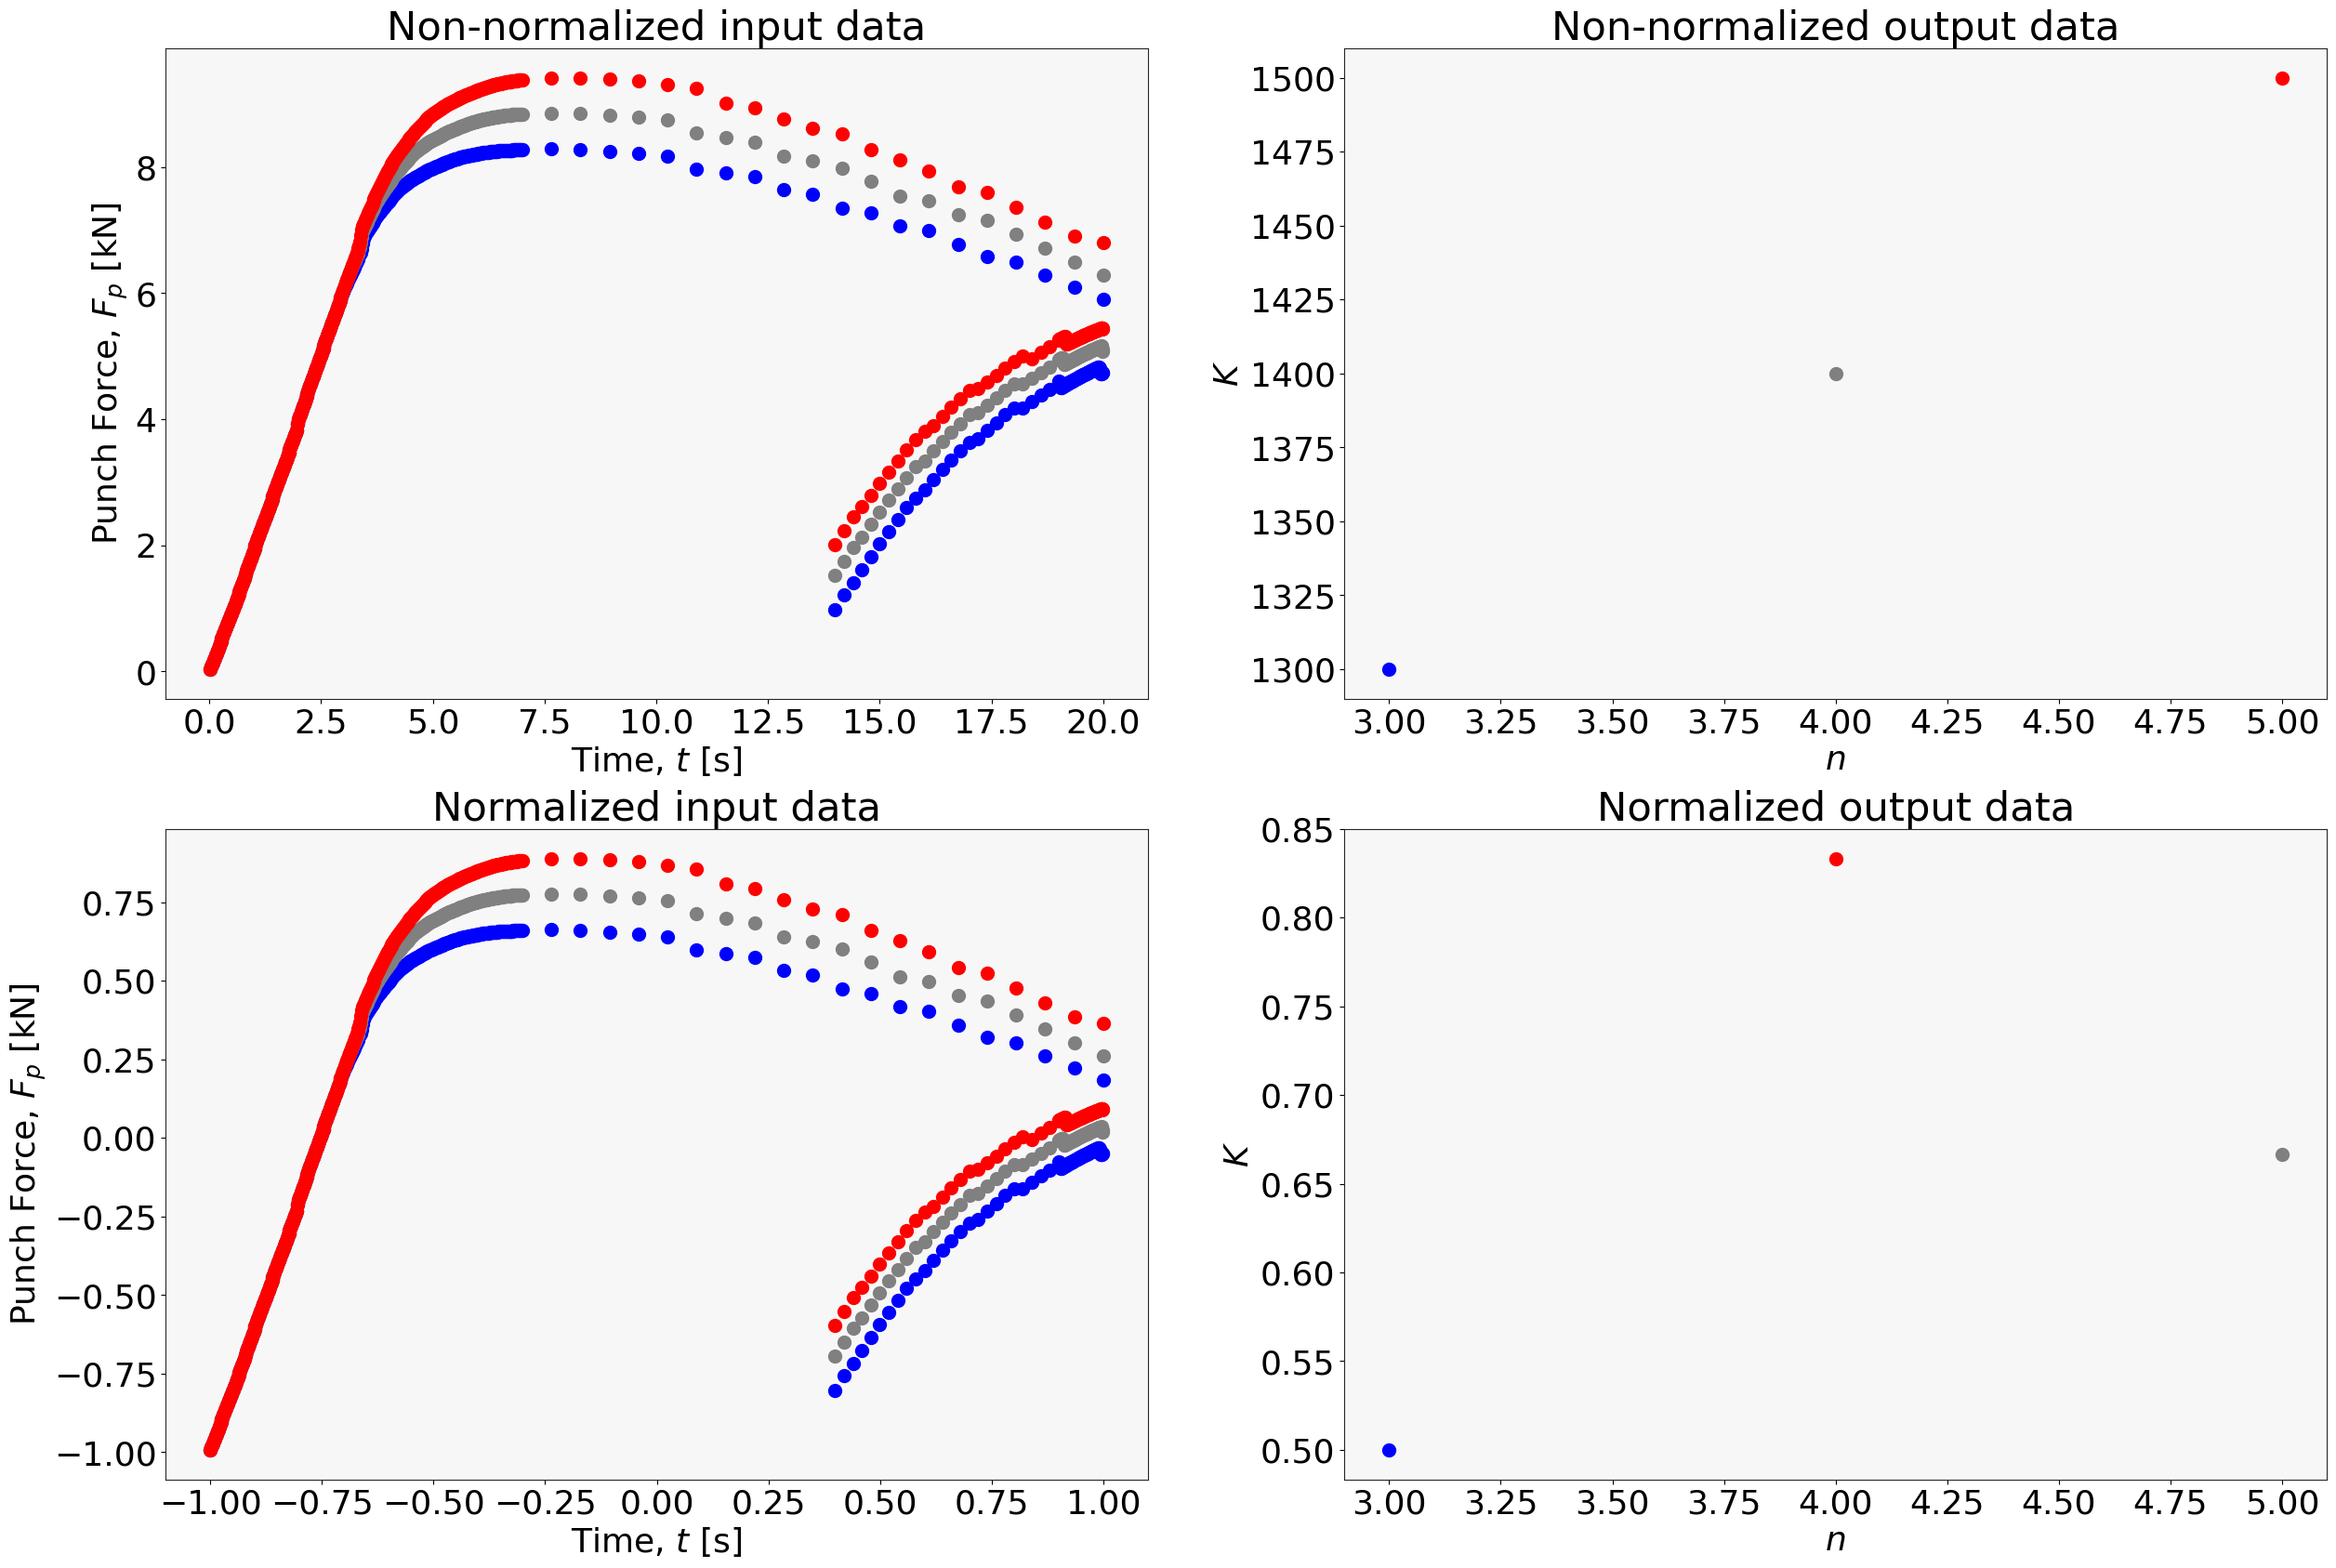

In [ ]:
#Plots with normalized and Non-normalized inputs
fig_ANN, ((ax1_ANN, ax2_ANN), (ax3_ANN, ax4_ANN)) = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

#Case Studies to represent
Case_1 = 3
Case_2 = 4
Case_3 = 5

#Force Displacement Curves
ax1_ANN.plot(X_data[Case_1,:,0], X_data[Case_1,:,1], 'o', markersize=10, color='blue', label="training points") # show Non-normalized training data
ax1_ANN.plot(X_data[Case_2,:,0], X_data[Case_2,:,1], 'o', markersize=10, color='gray', label="training points") # show Non-normalized training data
ax1_ANN.plot(X_data[Case_3,:,0], X_data[Case_3,:,1], 'o', markersize=10, color='red', label="training points") # show Non-normalized training data
ax1_ANN.set_ylabel('Punch Force, $F_p$ [kN]')
ax1_ANN.set_xlabel('Time, $t$ [s]')
ax1_ANN.set_title('Non-normalized input data')
#ax1_ANN.legen#d(['training', 'testing', 'validation' ], loc='best')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax1_ANN.set_ylim([0, 10])
# ax1_ANN.set_xlim([0, 20])

# K-n Points
ax2_ANN.plot(Case_1, Y_data[Case_1,0,:], 'o', markersize=10, color='blue') # show normalized training data
ax2_ANN.plot(Case_2, Y_data[Case_2,0,:], 'o', markersize=10, color='gray') # show normalized training data
ax2_ANN.plot(Case_3, Y_data[Case_3,0,:], 'o', markersize=10, color='red') # show normalized training data
ax2_ANN.set_ylabel('$K$')
ax2_ANN.set_xlabel('$n$')
ax2_ANN.set_title('Non-normalized output data')
# ax2_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax2_ANN.set_ylim([200, 1800])
# ax2_ANN.set_xlim([0, 0.4])

ax3_ANN.plot(X_data_scaled[Case_1,:,0], X_data_scaled[Case_1,:,1], 'o', markersize=10, color='blue', label="training points") # show Non-normalized training data
ax3_ANN.plot(X_data_scaled[Case_2,:,0], X_data_scaled[Case_2,:,1], 'o', markersize=10, color='gray', label="training points") # show Non-normalized training data
ax3_ANN.plot(X_data_scaled[Case_3,:,0], X_data_scaled[Case_3,:,1], 'o', markersize=10, color='red', label="training points") # show Non-normalized training data
ax3_ANN.set_ylabel('Punch Force, $F_p$ [kN]')
ax3_ANN.set_xlabel('Time, $t$ [s]')
ax3_ANN.set_title('Normalized input data')
#ax1_ANN.legen#d(['training', 'testing', 'validation' ], loc='best')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax3_ANN.set_ylim([-1, 1])
# ax3_ANN.set_xlim([-1, 1])

# K-n Points
ax4_ANN.plot(Case_1, Y_data_scaled[Case_1,0,:], 'o', markersize=10, color='blue') # show normalized training data
ax4_ANN.plot(Case_3, Y_data_scaled[Case_2,0,:], 'o', markersize=10, color='gray') # show normalized training data
ax4_ANN.plot(Case_2, Y_data_scaled[Case_3,0,:], 'o', markersize=10, color='red') # show normalized training data
ax4_ANN.set_ylabel('$K$')
ax4_ANN.set_xlabel('$n$')
ax4_ANN.set_title('Normalized output data')
# ax2_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax4_ANN.set_ylim([-1.25, 1.25])
# ax4_ANN.set_xlim([-1.25, 1.25])


# Create figure with specified size
# fig_ANN.set_size_inches(22, 10)

In [ ]:
print(Y_data_scaled[:,0,:])

In [ ]:
# Divide datasets into train and test 

seed = 1000 # set a random seed to replicate results
np.random.seed(seed)

testvalset_ratio = 0.2 # ratio of test set points from the dataset

X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_data_scaled, Y_data_scaled[:,0,:],
                                                    test_size=testvalset_ratio,random_state=seed
                                                    )

print(Y_train_scaled.shape)

(16, 1)


Text(0.5, 1.0, 'Normalized output data')

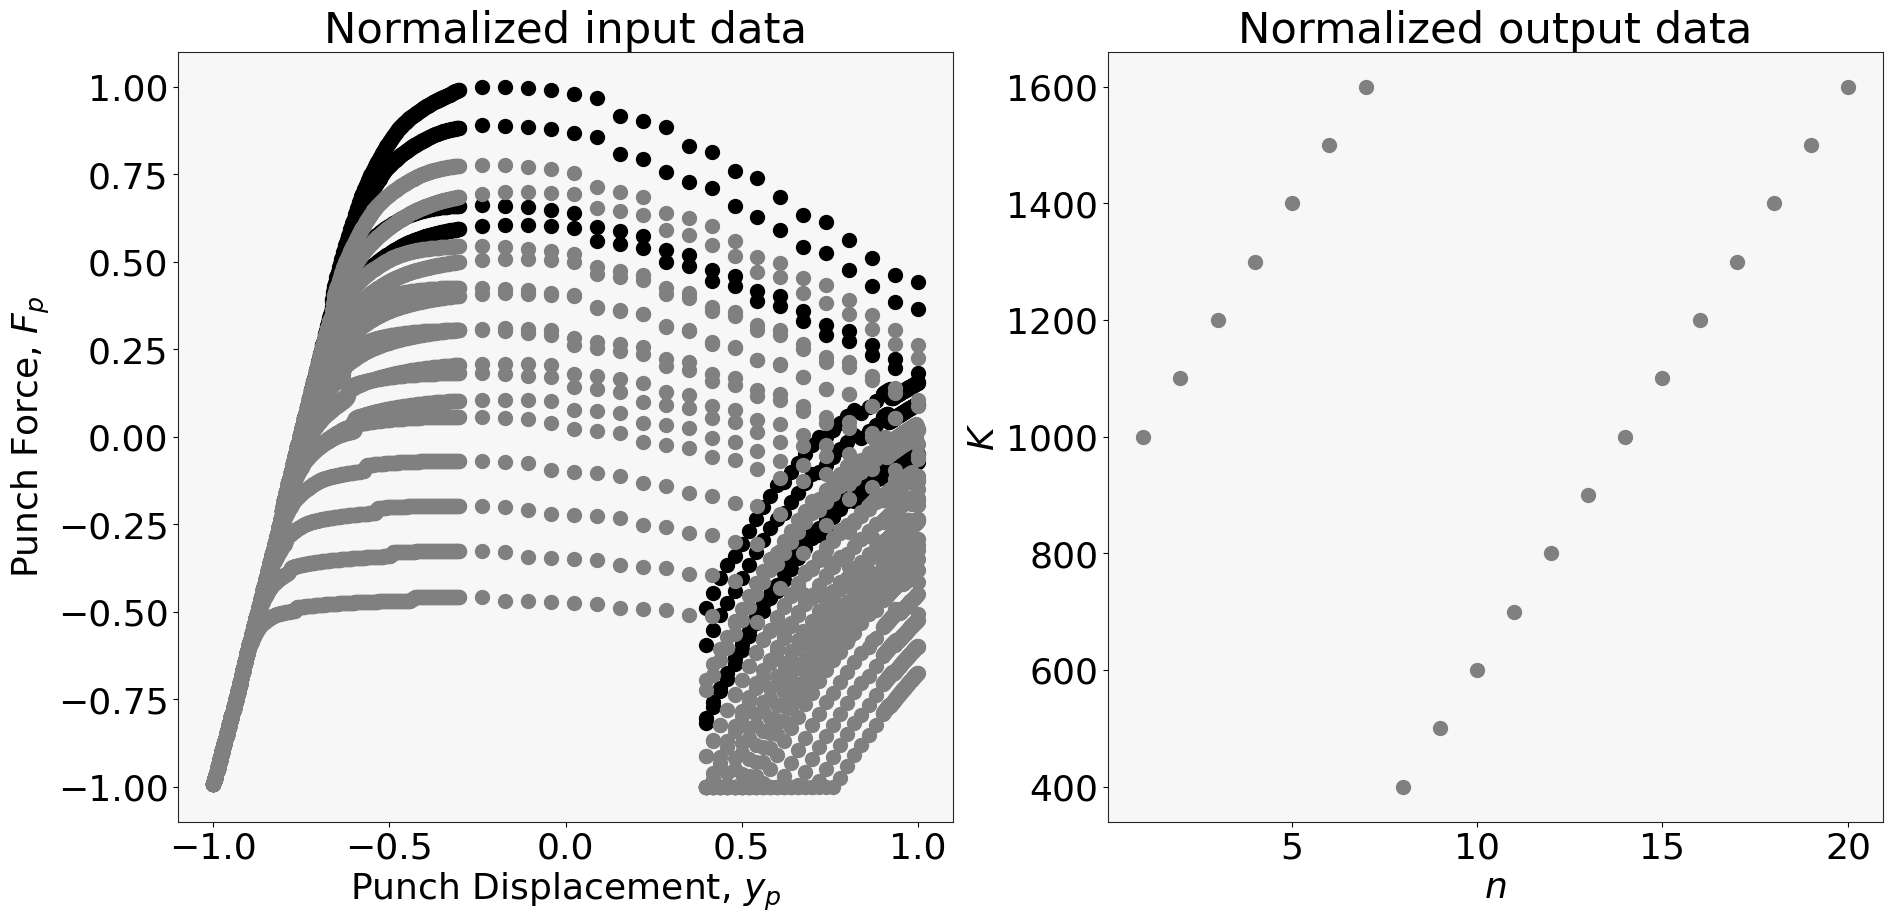

In [ ]:
#Plots with normalized and Non-normalized outputs
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)

cases = np.arange(1, n_cases+1, 1)

ax1_ANN.plot(X_test_scaled[:,:,0], X_test_scaled[:,:,1], 'o', markersize=10, color='black', label="testing points") # show normalized training data
ax1_ANN.plot(X_train_scaled[:,:,0], X_train_scaled[:,:,1], 'o', markersize=10, color='gray', label="training points") # show normalized training data
ax1_ANN.set_ylabel('Punch Force, $F_p$')
ax1_ANN.set_xlabel('Punch Displacement, $y_p$')
ax1_ANN.set_title('Normalized input data')
# ax1_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax1_ANN.set_ylim([-1.25, 1.25])
# ax1_ANN.set_xlim([-1.25, 1.25])
# Create figure with specified size
fig_ANN.set_size_inches(22, 10)

# K-n Points
ax2_ANN.plot(cases, Y_data[:,0,:], 'o', markersize=10, color='gray') # show normalized training data
# ax2_ANN.plot(cases, Y_test_scaled, 'o', markersize=10, color='black', label="testing points") # show normalized training data
ax2_ANN.set_ylabel('$K$')
ax2_ANN.set_xlabel('$n$')
ax2_ANN.set_title('Normalized output data')
# ax2_ANN.legend(['training', 'testing', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
# ax2_ANN.set_ylim([-1.25, 1.25])
# ax2_ANN.set_xlim([-1.25, 1.25])


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(500, 2), activation='tanh'))
model.add(Dense(100, activation = "tanh"))
model.add(Dense(1, activation = "linear"))

In [ ]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error',
              optimizer=opt)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,801
Trainable params: 15,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train_scaled, Y_train_scaled, validation_data=(X_test_scaled, Y_test_scaled), epochs=500,  batch_size = 500)

Epoch 1/500
1/1 [==============================] - 9s 9s/step - loss: 0.3234 - val_loss: 0.0555
Epoch 2/500
1/1 [==============================] - 0s 59ms/step - loss: 1.2402 - val_loss: 0.4832
Epoch 3/500
1/1 [==============================] - 0s 56ms/step - loss: 0.2914 - val_loss: 1.1554
Epoch 4/500
1/1 [==============================] - 0s 70ms/step - loss: 0.4612 - val_loss: 1.0965
Epoch 5/500
1/1 [==============================] - 0s 59ms/step - loss: 0.4271 - val_loss: 0.8247
Epoch 6/500
1/1 [==============================] - 0s 65ms/step - loss: 0.3243 - val_loss: 0.5859
Epoch 7/500
1/1 [==============================] - 0s 57ms/step - loss: 0.3004 - val_loss: 0.4342
Epoch 8/500
1/1 [==============================] - 0s 57ms/step - loss: 0.3275 - val_loss: 0.3777
Epoch 9/500
1/1 [==============================] - 0s 56ms/step - loss: 0.3405 - val_loss: 0.3885
Epoch 10/500
1/1 [==============================] - 0s 61ms/step - loss: 0.3242 - val_loss: 0.4380
Epoch 11/500
1/1 [===

(0.0, 1.0)

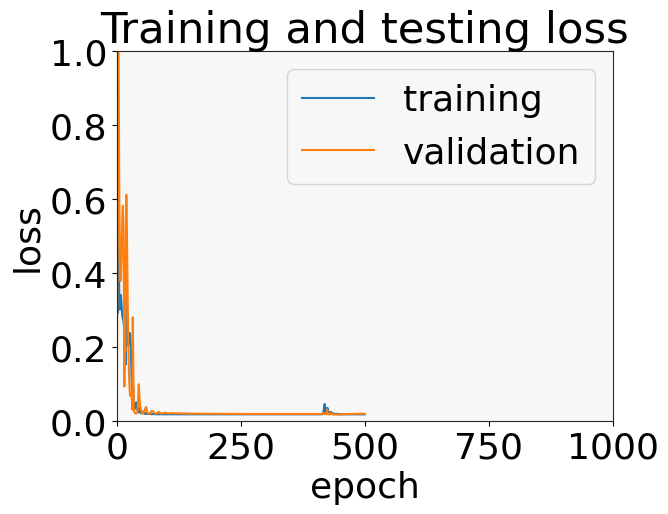

In [ ]:
fig_ANN, (ax1_ANN) = plt.subplots(1,1)

ax1_ANN.plot(history.history['loss'])
ax1_ANN.plot(history.history['val_loss'])
ax1_ANN.set_title('Training and testing loss')
ax1_ANN.set_ylabel('loss')
ax1_ANN.set_xlabel('epoch')
ax1_ANN.legend(['training', 'validation'], loc='upper right')
#ax1_ANN.grid(True, color='gray', linestyle='-')
ax1_ANN.set_xlim([0, 1000])
ax1_ANN.set_ylim([0, 1])

In [ ]:
Y_data_ANNpred_scaled = history.model.predict(X_data_scaled)
Y_data_ANNpred = scaler_y.inverse_transform(Y_data_ANNpred_scaled)
Y_data_ANNpred_scaled = Y_data_ANNpred_scaled.reshape(n_cases,1,1)
Y_data_ANNpred = Y_data_ANNpred.reshape(n_cases,1,1)


1/1 [==============================] - 0s 357ms/step


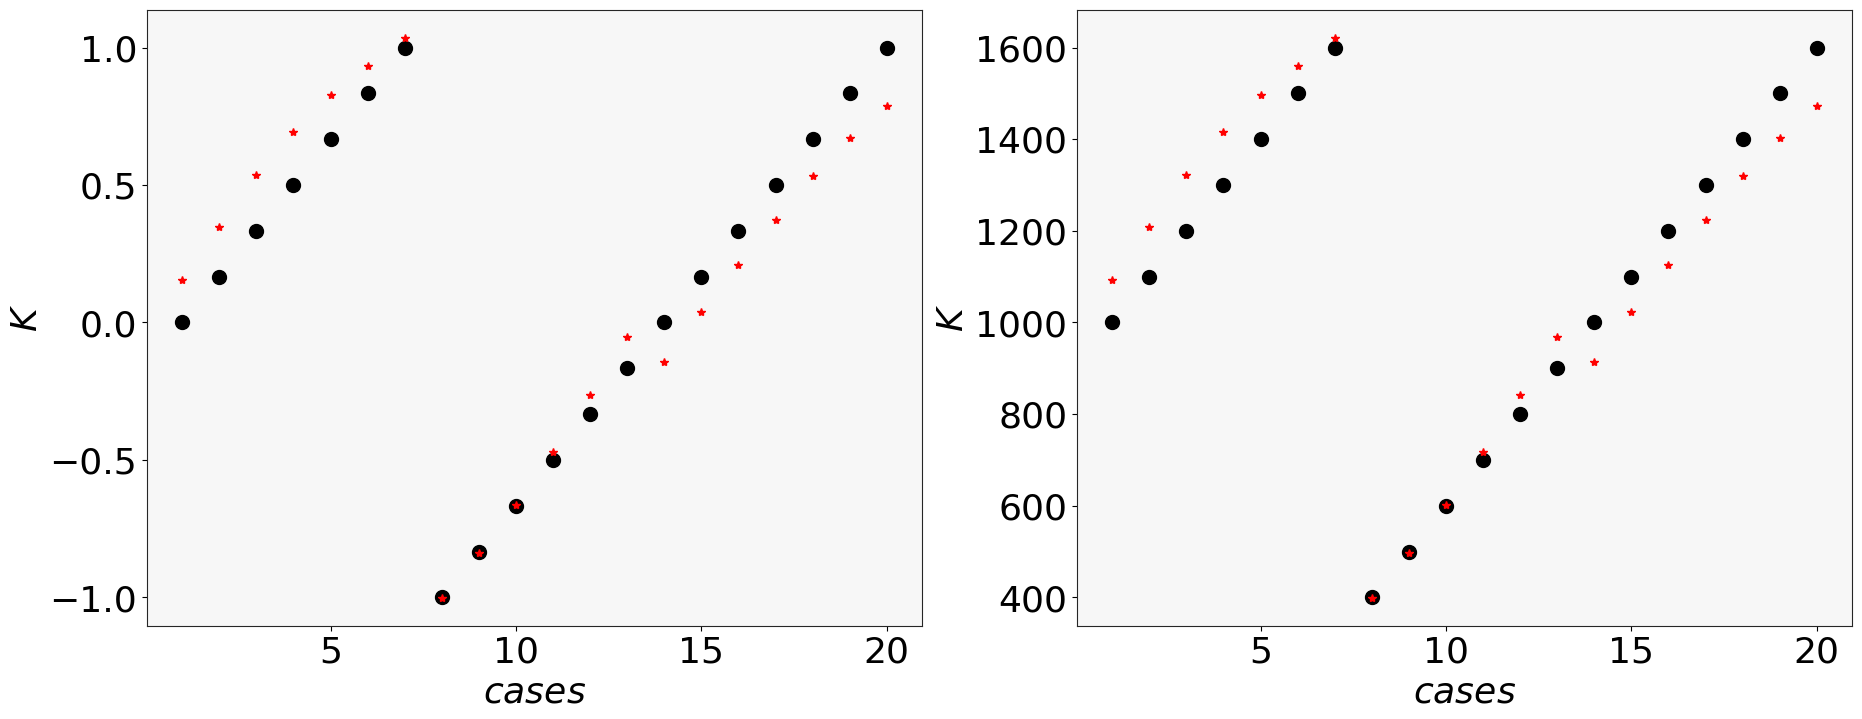

In [ ]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)

cases = np.arange(1, n_cases+1, 1)
ax1_ANN.plot(cases, Y_data_scaled[:,0,:], 'o', markersize=10, color='black', label="testing points") # show training data
ax1_ANN.plot(cases, Y_data_ANNpred_scaled[:,0,:], marker='*', linestyle='none', color='red', label="Neural Network prediction") # plot prediction
ax1_ANN.set_ylabel('$K$')
ax1_ANN.set_xlabel('$cases$')


ax2_ANN.plot(cases, Y_data[:,0,:], 'o', markersize=10, color='black', label="testing points") # show training data
ax2_ANN.plot(cases, Y_data_ANNpred[:,0,:], marker='*', linestyle='none', color='red', label="Neural Network prediction") # plot prediction
ax2_ANN.set_ylabel('$K$')
ax2_ANN.set_xlabel('$cases$')

# ax2_ANN.plot(Y_data[:,1,:], Y_data[:,0,:], 'o', markersize=10, color='gray', label="training points") # show training data
# ax2_ANN.plot(Y_data_ANNpred[:,1], Y_data_ANNpred[:,0], marker='*', linestyle='none', color='red', label="Neural Network prediction") # plot prediction
# ax2_ANN.set_ylabel('$K$')
# ax2_ANN.set_xlabel('$n$')
# # ax2_ANN.legend(loc='best')
# ax2_ANN.set_xlim([0, 0.4])
# ax2_ANN.set_ylim([200, 1800])
#ax2_ANN.grid(True, color='gray', linestyle='-')
# Create figure with specified size
fig_ANN.set_size_inches(22, 8)